<a href="https://colab.research.google.com/github/llathieyre/01/blob/main/Outliers_and_Anomaly_Detection_with_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Documentation [here](https://medium.com/@reza.rajabi/outlier-and-anomaly-detection-using-facebook-prophet-in-python-3a83d58b1bdf).
First, we import Facebook Prophetlibrary:

In [ ]:
# Installing fbprophet using pip. The ! ensures the command is run in the system shell.
!pip install prophet
# Importing the fbprophet module to use its functionalities.
import prophet

We load the data into a dataframe (The code and data are available at my [GitHub](https://github.com/erajabi/anomaly_detection/blob/main/data.csv)):

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving nyc_taxi.csv to nyc_taxi (1).csv


In [ ]:
import pandas as pd
import numpy as np
# sale = pd.read_csv('./data.csv')
sale = pd.read_csv('./nyc_taxi.csv')
sale.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [ ]:
sale.describe()

,value
count,10320.000000
mean,15137.569380
std,6939.495808
min,8.000000
25%,10262.000000
50%,16778.000000
75%,19838.750000
max,39197.000000


We can visualize this time-series dataset in a line graph:

In [ ]:
import plotly.express as px
sale = sale.sort_values(by='timestamp')
sale['timestamp'] = sale['timestamp'].apply(pd.to_datetime)
fig = px.line(sale, x='timestamp', y='value',  title='Sale quantity')
fig.update_layout( template='none')

# Calculate the moving average
window_size = 50  # Adjust the window size as needed
sale['moving_average'] = sale['value'].rolling(window=window_size, center=True).mean()

# Add the moving average to the chart
fig = px.line(sale, x='timestamp', y='value', title='Sale quantity')
fig.add_scatter(x=sale['timestamp'], y=sale['moving_average'], mode='lines', name='Moving Average')
fig.update_layout(template='none')

# Calculate standard deviation
sale['std_dev'] = sale['value'].rolling(window=window_size, center=True).std()

# Calculate upper and lower limits
sale['upper_limit'] = sale['moving_average'] + 2.0 * sale['std_dev']
sale['lower_limit'] = sale['moving_average'] - 2.0 * sale['std_dev']

# Add upper and lower limits to the chart
fig = px.line(sale, x='timestamp', y='value', title='Sale quantity with Upper and Lower Limits')
fig.add_scatter(x=sale['timestamp'], y=sale['moving_average'], mode='lines', name='Moving Average')
fig.add_scatter(x=sale['timestamp'], y=sale['upper_limit'], mode='lines', name='Upper Limit')
fig.add_scatter(x=sale['timestamp'], y=sale['lower_limit'], mode='lines', name='Lower Limit')
fig.update_layout(template='none')

fig.show()

# Identify outliers
sale['outlier'] = (sale['value'] > sale['upper_limit']) | (sale['value'] < sale['lower_limit'])

# Print or further process outliers if needed
print(sale[sale['outlier']])

                timestamp  value  moving_average      std_dev   upper_limit  \
134   2014-07-03 19:00:00  29985        15004.90  6073.810969  27152.521937   
203   2014-07-05 05:30:00   2514        11435.56  4420.856608  20277.273216   
204   2014-07-05 06:00:00   2550        11484.96  4442.238358  20369.436716   
490   2014-07-11 05:00:00   3134        16260.72  6500.373132  29261.466265   
539   2014-07-12 05:30:00   3682        16984.44  6642.437821  30269.315643   
...                   ...    ...             ...          ...           ...   
9660  2015-01-18 06:00:00   3050        17844.90  7297.985308  32440.870617   
9661  2015-01-18 06:30:00   3114        17795.64  7269.821250  32335.282501   
9996  2015-01-25 06:00:00   2793        16934.62  6968.247895  30871.115791   
10283 2015-01-31 05:30:00   3329        18829.12  7537.415135  33903.950271   
10284 2015-01-31 06:00:00   3714        18998.62  7603.501876  34205.623751   

       lower_limit  outlier  
134    2857.278063   

We should prepare the dataset to fit the model. To this end, we rename the column accordingly:


In [ ]:
# sale.rename(columns={'quantity':'y','hour_col':'ds'}, inplace=True)
sale.rename(columns={'value':'y','timestamp':'ds'}, inplace=True)
sale.head()

,ds,y,moving_average,std_dev,upper_limit,lower_limit,outlier
0,2014-07-01 00:00:00,10844,NaN,NaN,NaN,NaN,False
1,2014-07-01 00:30:00,8127,NaN,NaN,NaN,NaN,False
2,2014-07-01 01:00:00,6210,NaN,NaN,NaN,NaN,False
3,2014-07-01 01:30:00,4656,NaN,NaN,NaN,NaN,False
4,2014-07-01 02:00:00,3820,NaN,NaN,NaN,NaN,False


In [ ]:
from prophet import Prophet # Import the Prophet class from the prophet module
m = Prophet(changepoint_range=0.8, changepoint_prior_scale=0.05) # Instantiate a Prophet object

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjtljlk6f/nij3jw85.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjtljlk6f/yt54vr5j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55603', 'data', 'file=/tmp/tmpjtljlk6f/nij3jw85.json', 'init=/tmp/tmpjtljlk6f/yt54vr5j.json', 'output', 'file=/tmp/tmpjtljlk6f/prophet_modelqn1bw36_/prophet_model-20250419201117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1854: FutureWarning:

'H' is deprecated and will be removed in a future versio

Mean Absolute Error (MAE): 2734.3
Median Absolute Error (MedAE): 2108.5
Mean Squared Error (MSE): 13208369.62
Root Mean Squared Error (RMSE): 3634.33
Mean Absolute Percentage Error (MAPE): 0.27 %


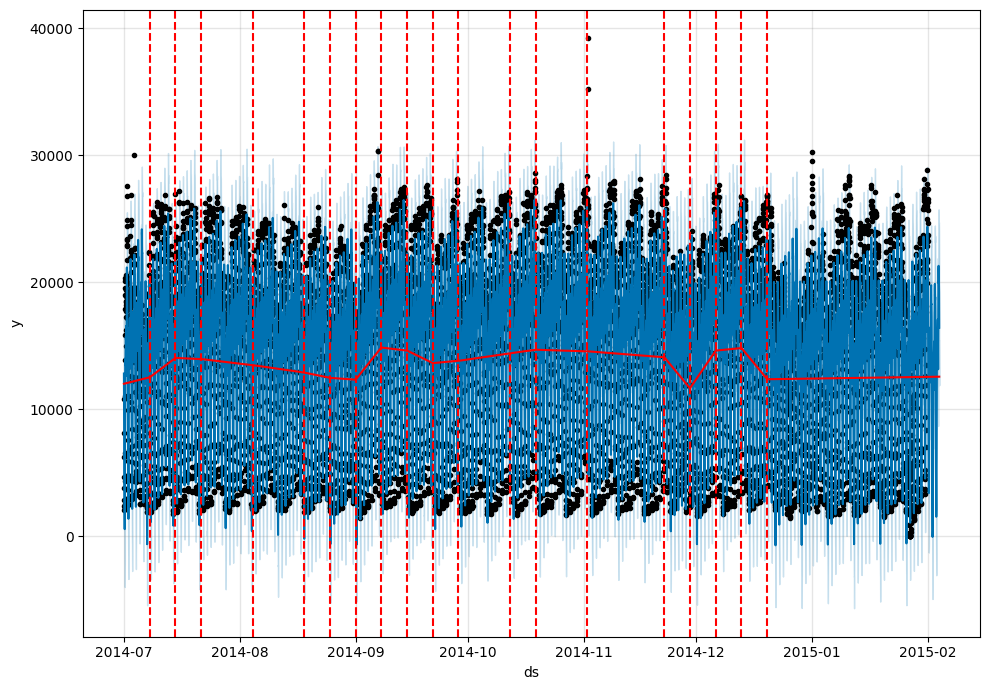

In [ ]:
# changepoint_range=0.8
changepoint_range=1
changepoint_prior_scale=0.05 # 0.05. Increasing it will make the trend more flexible
seasonality_period=1 # it is repeated everyday
fourier_order=100
future_period = 72 # future days
future_period_freq ='H'
m = Prophet( changepoint_range=0.8, changepoint_prior_scale=0.5)
# period is per day (0.5 = 12 hours); fourier_order:
# to what extent it can capture points in one period of time (bigger = wider)
# For reference, by default Prophet uses a Fourier order of 3 for weekly seasonality and
# 10 for yearly seasonality. An optional input to add_seasonality is the prior scale for that seasonal component
m.add_seasonality(name='hourly', period=seasonality_period, fourier_order=future_period)

m.fit(sale)

# For upcoming 48 hours
future = m.make_future_dataframe(periods=future_period, freq=future_period_freq)
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(10, 7))
# a = add_changepoints_to_plot(fig.gca(), m, forecast)

forecast_df = forecast[['ds','yhat','yhat_upper','yhat_lower']]
forecast_df
forecast_df['yhat'] = forecast_df['yhat'].astype(int)
# Convert 'ds' column in sale to datetime
sale['ds'] = pd.to_datetime(sale['ds'])
# Now perform the merge
forecasting_final = pd.merge(forecast_df, sale, how='inner', left_on = 'ds', right_on = 'ds')
# Calculate the errors and uncertainty
forecasting_final['error'] = forecasting_final['y'] - forecasting_final['yhat']
forecasting_final['uncertainty'] = forecasting_final['yhat_upper'] - forecasting_final['yhat_lower']

from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt
from prophet.plot import add_changepoints_to_plot

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(forecasting_final['yhat'],forecasting_final['y'])
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = median_absolute_error(forecasting_final['yhat'],forecasting_final['y'])
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = mean_squared_error(forecasting_final['yhat'],forecasting_final['y'])
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE)
RMSE = sqrt(int(mean_squared_error(forecasting_final['yhat'],forecasting_final['y'])))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_absolute_percentage_error(forecasting_final['yhat'],forecasting_final['y'])
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

a = add_changepoints_to_plot(fig.gca(), m, forecast)

We can define an error and a confidence level based on lower and upper-level predictions. We can merge this dataframe with the sale dataset to get the values. We can use a factor to compare the error with the confidence level to identify the outliers. If the error is greater than the uncertainty factor (e.g., 1.5 greater than uncertainty), we can consider that specific record as a potential anomaly.

In [ ]:
#Merging two dataset to have the actual and prediction values
forecasting_final = pd.merge(forecast_df, sale, how='inner',
                                     left_on = 'ds', right_on = 'ds')

# We calculate the prediction error here and uncertainty
forecasting_final['error'] = forecasting_final['y'] - forecasting_final['yhat']
forecasting_final['uncertainty'] = forecasting_final['yhat_upper'] - forecasting_final['yhat_lower']

# We this factor we can identify the outlier or anomaly.
# This factor can be customized based on the data
factor = 1
forecasting_final['anomaly'] = forecasting_final.apply(lambda x: 'Yes'
      if(np.abs(x['error']) >  factor*x['uncertainty']) else 'No', axis = 1)

In [ ]:
color_discrete_map = {'Yes': 'rgb(255,12,0)', 'No': 'blue'}
fig = px.scatter(forecasting_final, x='ds', y='y', color='anomaly', title='Anomaly',
                 color_discrete_map=color_discrete_map)
fig.show()